# Image Forgery Detection

In 2013 IEEE Information Forensics and Security Technical Committee (IFS-TC) established the First IFS-TC Image Forensics
Challenge

**Fake image**: An image that has been manipulated/doctored using the two most common manipulation operations namely: copy/pasting and image splicing.

**Pristine image**: An image that has not been manipulated except for the resizing needed to bring all images to a standard size as per competition rules.

**Image splicing**: The splicing operations can combine images of people, adding doors to buildings, adding trees and cars to parking lots etc. The spliced images can also contain resulting parts from copy/pasting operations. The image receiving a spliced part is called a “host” image. The parts being spliced together with the host image are referred to as “aliens”

**Dataset Overview:**

The dataset consists of 1050 pristine, 450 fake images and 450 Ground truths. Color images are usually 3 channel images one channel for each red, green and blue colors, however sometimes the fourth channel for yellow may be present. Images in our dataset are a mix of 1, 3 and 4 channel images.

**Objective:**

Given image data, we need to descriminate whether a given image is pristine or fake.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import Libraries 

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import PIL
import numpy as np
import pandas as pd
import os
import tarfile
from PIL import Image
import matplotlib
from tqdm import tqdm_notebook, tnrange
from PIL import Image, ImageChops, ImageEnhance

from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from itertools import chain
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam,SGD
from keras import optimizers
from tensorboardcolab import TensorBoardColab,TensorBoardColabCallback
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model
from keras.applications import vgg16 as vgg
from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet101
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import roc_curve, auc,roc_auc_score

from tqdm import tqdm
import cv2
import shutil

# https://github.com/albu/albumentations

from albumentations import (
    IAAPerspective, ShiftScaleRotate, CLAHE, 
     ShiftScaleRotate, Blur,   HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
	PadIfNeeded,HorizontalFlip,VerticalFlip, CenterCrop, Crop, Compose, Transpose, RandomRotate90, ElasticTransform, 
    GridDistortion, OpticalDistortion, RandomSizedCrop, OneOf, CLAHE, RandomBrightnessContrast, RandomGamma, ChannelShuffle,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, RandomGamma, RGBShift, Rotate
)

#Error Level Analysis

https://gist.github.com/ewencp/3356622

https://forensics.map-base.info/report_2/index_en.shtml#b

https://fotoforensics.com/tutorial-ela.php

https://www.youtube.com/watch?v=G1Y0UTMTF7o&t=671s

https://29a.ch/photo-forensics/#error-level-analysis  -  Tool to understand how it works


Error Level Analysis is based on characteristics of image formats that are based on lossy image compression. This method can highlight areas of an image which has different degrees of compression. Especially the JPEG format (one of the most popular image formats on the Internet) can be applied particularly well using this method.

For a better understanding it is necessary to know how images in JPEG format are created. JPEG uses a lossy image compression. Each re-encoding process (new saving) performed on the image leads to further loss of quality. The JPEG algorithm is based on a 8x8 pixel grid. Each 8x8 square grid is thereby treated and compressed separately. If the image is untouched, then all these 8x8 squares will show the same error level potential.

If the jpeg image is saved again, then each square should be continuously reduced to approximately the same level. In the ELA process, the original image that is being examined will be resaved at a certain JPEG quality level (for example, at 75%). The resave leads to a known degree of compression, which extends over the entire image. The newly saved image is used to be compared with the original image. The human eye would hardly notice a change. Therefore, the ELA representation will visualize in particular only the difference between the two images. So, the resulting ELA image shows the varying degrees of compression potentials.

![alt text](https://forensics.map-base.info/report_2/grafx/ela_method_en.jpg)

In [0]:
%%time

if not os.path.exists(path+'aug_data_512/ELA_Images'):
    os.makedirs(path+'aug_data_512/ELA_Images')
    
    for file in (os.listdir(path+'aug_data_512/images')):
        filename = path+'aug_data_512/images/{}'.format(file)
        resaved = '.resaved.jpg'
        ela = path+'aug_data_512/ELA_Images/{}'.format(file)
        im = Image.open(filename).convert("RGB")
        im.save(resaved, 'JPEG', quality=95) # try different JPEG quality levels.
        resaved_im = Image.open(resaved)
        ela_im = ImageChops.difference(im, resaved_im)
        extrema = ela_im.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        scale = 255.0/max_diff
        ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
        ela_im.save(ela)
    print("DONE Converting to ELA!")
else:
    print("Already Exists!")

In [0]:
# %%time
if not os.path.exists(path+"total_images_512"):
    os.makedirs(path+"total_images_512/masks")
    os.makedirs(path+"total_images_512/images")
    for i,val in enumerate(fake_imageIDs):
        actual_image=fake_dir+val+".png"
        img=Image.open(actual_image).convert("RGB")
        image_id="image{}.png".format(i)
        height = 512
        width = 512
        img = img.resize((height, width), PIL.Image.ANTIALIAS)
        img.save(path+"total_images_512/images/"+image_id)
        #PATH_mask=PATH[:-3]+'mask.png'
        mask_image=val+".mask.png"
        mask=Image.open(fake_dir+mask_image).convert("RGB")
        #hpercent = (baseheight / float(mask.size[1]))
        #wsize = int((float(mask.size[0]) * float(hpercent)))
        mask = mask.resize((height, width), PIL.Image.ANTIALIAS)
        mask_id="mask{}.png".format(i)
        mask.save(path+"total_images_512/masks/"+mask_id)
    print("Done Resizing for fake images and masks")  
else:
    print("Directories are already present in the path")

In [0]:
# %%time
for i,val in enumerate(pristine_imageIDs):
    actual_image=pristine_dir+val+".png"
    img=Image.open(actual_image).convert("RGB")
    image_id="image{}.png".format(450+i)
    height = 512
    width = 512
    img = img.resize((height, width), PIL.Image.ANTIALIAS)
    img.save(path+"total_images_512/images/"+image_id)
print("Done Resizing for pristine") 


In [0]:
ela_image_files_fake ='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/ELA_Images/'
masks_files='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/masks/'
path ='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/'

len(os.listdir(ela_image_files_fake )),len(os.listdir(masks_files))

(450, 450)

In [0]:
ela_image_files_fake

'/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/ELA_Images/'

In [0]:
ela_image_files = []
ela_image_files_pos = []
ela_image_files_fake = []
for i in range(450):
    ela_image_path_fake="/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/ELA_Images/image{}.png".format(i)
    ela_image_files_fake.append(ela_image_path_fake)
for i in range(4050,5100):
    ela_image_path_pos=path+"aug_data_512/ELA_Images/image{}.png".format(i)
    ela_image_files_pos.append(ela_image_path_pos)

ela_image_files.extend(ela_image_files_fake)
ela_image_files.extend(ela_image_files_pos)

len(ela_image_files)

1500

# Train-Test Split

In [0]:
# Here we choose 1800 fake images(after augmentation) and 1050 pristine images.

class_labels = [0]*450+[1]*1050  

# Stratify - it is often chosen to ensure that the train and test sets have approximately the same percentage of samples of each target class as the complete set.
X_train, X_test, y_train, y_test = train_test_split(ela_image_files,class_labels , test_size=0.12,stratify=class_labels, random_state=143)
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train , test_size=0.10,stratify=y_train, random_state=143)

In [0]:
len(X_train),len(X_cv),len(X_test)

(1188, 132, 180)

In [0]:
# X_train

In [0]:
import re
fake_train_files = []
for i in range(len(X_train)):
    if (int(re.findall('\d+', X_train[i])[2])) < 450:
        fake_train_files.append(X_train[i])
len(fake_train_files)

356

#Data Augmentation

**About Albumentation Library**

1. The library is faster than other libraries on most of the transformations.

2. Based on numpy, OpenCV, imgaug picking the best from each of them.

3. Simple, flexible API that allows the library to be used in any computer         vision pipeline.

4. Large, diverse set of transformations.

5. Written by Kaggle Masters.

In [0]:
# https://www.kaggle.com/alexanderliao/image-augmentation-demo-with-albumentation

# Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.
# Since our dataset is very small we will apply a large number of different augmentations

# Please find the below link for data augmentation and error level analysis code. All the preprocessing was done over there.

# https://github.com/gurram1223/Image-Forgery-Detection/blob/master/Image_Forgery_Localization.ipynb

In [0]:
%%time

def horizontalFlip(image):
    aug = HorizontalFlip(p=1)
    augmented = aug(image=image)
    image_hflip = augmented['image']
    return image_hflip

def verticalFlip(image):
    aug = VerticalFlip(p=1)
    augmented = aug(image=image)
    image_vflip = augmented['image']
    return image_vflip

#################################################

if not os.path.isfile(path+"phase_1"):
    os.makedirs(path+"phase_1/aug_only_images")

w = 8000
for i,val in enumerate(fake_train_files):

    image=cv2.imread(val)

    h=horizontalFlip(image)
    imgh=Image.fromarray(h)
    imgh.save(path+'phase_1/aug_only_images/image{}.png'.format(w+1))
    
    v=verticalFlip(image)
    imgv=Image.fromarray(v)
    imgv.save(path+'phase_1/aug_only_images/image{}.png'.format(w+2))

    w = w+3

CPU times: user 1min 46s, sys: 910 ms, total: 1min 47s
Wall time: 1min 54s


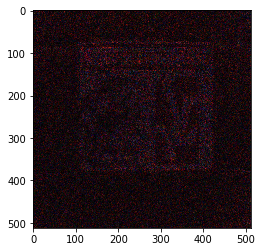

In [0]:
plt.imshow(imgv)

In [0]:
aug_only_train = "/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/phase_1/aug_only_images/"
len(os.listdir(aug_only_train))

712

In [0]:
ela_aug_only = []
ela_aug_only_path = "/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/phase_1/aug_only_images/"
for i,img in enumerate(os.listdir(aug_only_train)):
    ela_aug_only.append(ela_aug_only_path+img)
X_train.extend(ela_aug_only)
y_train.extend([0]*len(os.listdir(aug_only_train)))

In [0]:
import pickle

with open(aug_only_train+'X_train', 'wb') as f:
    pickle.dump(X_train, f)

with open(aug_only_train+'X_cv', 'wb') as f:
    pickle.dump(X_cv, f)
    
with open(aug_only_train+'X_test', 'wb') as f:
    pickle.dump(X_test, f)

with open(aug_only_train+'y_train', 'wb') as f:
    pickle.dump(y_train, f)

with open(aug_only_train+'y_cv', 'wb') as f:
    pickle.dump(y_cv, f)
    
with open(aug_only_train+'y_test', 'wb') as f:
    pickle.dump(y_test, f) 

In [0]:
with open(aug_only_train+'X_train', 'rb') as f:
    X_train = pickle.load(f)

with open(aug_only_train+'X_cv', 'rb') as f:
    X_cv = pickle.load(f)

with open(aug_only_train+'X_test', 'rb') as f:
    X_test = pickle.load(f)

with open(aug_only_train+'y_train', 'rb') as f:
    y_train = pickle.load(f)

with open(aug_only_train+'y_cv', 'rb') as f:
    y_cv = pickle.load(f)

with open(aug_only_train+'y_test', 'rb') as f:
    y_test = pickle.load(f)

In [0]:
len(X_train),len(y_train)

(1900, 1900)

In [0]:
num_classes = 2

# input image dimensions
img_rows, img_cols = 512, 512

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)
    
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_cv = keras.utils.to_categorical(y_cv, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# vgg16_model = vgg.VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
# for layer in vgg16_model.layers[4:]:
#     layer.trainable = False

# Resnet 
resnet_model = ResNet50(include_top=False, weights='imagenet',input_shape=input_shape)
#resnet_model.layers[0].trainable = False

In [0]:
resnet_model.summary()

#Modelling

**AUC:**

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

AUC provides an aggregate measure of performance across all possible classification thresholds. 

One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example.

AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

AUC is desirable for the following two reasons:

 1.  AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.

 2.  AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.

In [0]:
def roc_auc(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auc(y_true, y_pred):
    return tf.py_func(roc_auc, (y_true, y_pred), tf.double)

In [0]:
'''# Tried using transfer learning techniques(vgg16,resnet50,resnet101..). When compared we are getting the same results even with basic architecture implemented below.

batch_size = 64
num_classes = 2
epochs = 30

# Sequential model 

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=input_shape,kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))          
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5), activation='relu',padding='same',kernel_initializer='he_normal'))          
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
                 
model.add(Flatten())
                 
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.35))
model.add(BatchNormalization())
                 
model.add(Dense(num_classes, activation='softmax'))

# Configures the model for training.
model.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.Adam(),metrics=[auc])'''

In [0]:
#del model
model=Sequential()
model.add(resnet_model)

top_model=Sequential()
#top_model.add(Flatten(input_shape=(16, 16, 2048)))
top_model.add(Flatten(input_shape=(16, 16, 2048)))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.45))
top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.4))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dense(32, activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dense(2, activation='softmax'))

model.add(top_model)

for layer in model.layers[0].layers[:171]:
    layer.trainable=False

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.00015), metrics=[auc])

In [0]:
# Loading images batchwise using generator

def LoadImages(batch):
    return np.array([resize(imread(file_name), (512, 512, 3))for file_name in batch])

def loadImagesBatchwise(X_train,y_train, batch_size):
    train_image_files=X_train
    L = len(train_image_files)
    while True:
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:
            limit = min(batch_end, L)
            X = LoadImages(train_image_files[batch_start:limit])
            #X = X/255.0
            Y = y_train[batch_start:limit]
            yield (X,Y)
            batch_start += batch_size
            batch_end += batch_size
 

In [0]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://41d4bdc2.ngrok.io


In [0]:
%%time

# Fitting the model

batch_size=8
num_training_samples=len(X_train)
num_validation_samples=len(X_cv)
num_epochs=20

# Save the model after every epoch.
filepath = '/content/drive/My Drive/COLAB FILES/Image Forensics/model_detection.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath,monitor='val_auc',save_best_only=True, mode='max')

# Stop training when a monitored quantity has stopped improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.22, patience = 1, verbose = 1, min_delta = 0.0001)

# train model
results=model.fit_generator(loadImagesBatchwise(X_train,y_train,batch_size),steps_per_epoch=(num_training_samples // batch_size), epochs=num_epochs,
                            validation_data=loadImagesBatchwise(X_cv,y_cv,batch_size),validation_steps=num_validation_samples//batch_size,
                         verbose=2,callbacks=[TensorBoardColabCallback(tbc),early_stop,reduce_lr,checkpoint])

Epoch 1/20
 - 173s - loss: 0.9155 - auc: 0.4959 - val_loss: 0.6618 - val_auc: 0.5008
Epoch 2/20
 - 161s - loss: 0.8125 - auc: 0.5350 - val_loss: 0.6071 - val_auc: 0.7022
Epoch 3/20
 - 165s - loss: 0.7381 - auc: 0.6029 - val_loss: 0.5607 - val_auc: 0.6629
Epoch 4/20
 - 163s - loss: 0.6969 - auc: 0.6634 - val_loss: 0.5044 - val_auc: 0.7315
Epoch 5/20
 - 166s - loss: 0.6567 - auc: 0.6988 - val_loss: 0.5226 - val_auc: 0.7558

Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.300000156741589e-05.
Epoch 6/20
 - 158s - loss: 0.6339 - auc: 0.7101 - val_loss: 0.5184 - val_auc: 0.7719

Epoch 00006: ReduceLROnPlateau reducing learning rate to 7.260000056703575e-06.
Epoch 7/20
 - 160s - loss: 0.6101 - auc: 0.7359 - val_loss: 0.5374 - val_auc: 0.7687

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.5972000164765632e-06.
Epoch 8/20
 - 157s - loss: 0.6144 - auc: 0.7411 - val_loss: 0.5481 - val_auc: 0.7722

Epoch 00008: ReduceLROnPlateau reducing learning rate to 3.5138400562573223

#Plots

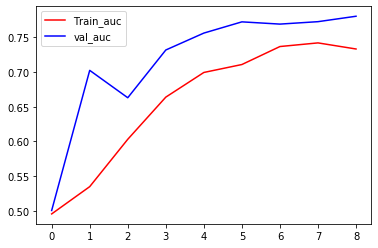

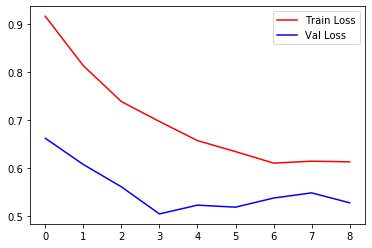

In [0]:
# Performance
plt.plot(results.history['auc'], 'r')
plt.plot(results.history['val_auc'], 'b')
plt.legend({'Train_auc': 'r', 'val_auc':'b'})
plt.show()

# Loss
plt.plot(results.history['loss'], 'r')
plt.plot(results.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Val Loss':'b'})
plt.show()

#Predictions

In [0]:
filepath = '/content/drive/My Drive/COLAB FILES/Image Forensics/model_detection.hdf5'
model.load_weights(filepath) # loads the weights of the model from a HDF5 file
test_images=LoadImages(X_test) # loading test images
predicted=model.predict(test_images)  # Generates output predictions for the input samples.

In [0]:
# Scores

print("Test-Loss: ",model.evaluate(test_images,y_test)[0])
print("Test-Score: ",model.evaluate(test_images,y_test)[1])

180/180 [==============================] - 8s 43ms/step
Test-Loss:  0.49839989609188506
180/180 [==============================] - 8s 43ms/step
Test-Score:  0.8024291620215532


In [0]:
'''# Confusion Matrix

import sklearn
y_pred = (predicted > 0.5) 
cm = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
cm'''

'# Confusion Matrix\n\nimport sklearn\ny_pred = (predicted > 0.5) \ncm = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))\ncm'

#Conclusions

In [1]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["CNN Model", "Train Score", "CV Score", "Test Score"]

x.add_row(["Basic Layers", 0.75,0.78,0.80])

print(x)

+--------------+-------------+----------+------------+
|  CNN Model   | Train Score | CV Score | Test Score |
+--------------+-------------+----------+------------+
| Basic Layers |     0.75    |   0.78   |    0.8     |
+--------------+-------------+----------+------------+


Here we used error level analysis technique to detect whether an image is pristine or fake.

We tried transfer learning techniques such as vgg16,resnet50,resnet101.., but with Resnet50, we are getting the good results.

There are also other ways to detect forged image.
Noise Analysis – This is basically a reverse denoising algorithm. Rather than removing the noise, it removes the rest of the image. It is using a super simple separable median filter to isolate the noise. It can be useful for identifying manipulations to the image like airbrushing, deformations, warping, and perspective corrected cloning. It works best on high-quality images.

With the above architecture and some parameter setting, we got 80% with test data